In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as spst
import shapely.geometry as geom
import geopandas as gpd
import sklearn as sklearn
from sklearn import cluster
from sklearn import preprocessing
from matplotlib.colors import ListedColormap
%matplotlib inline
from rnn import RNN, MetaRNN

In [2]:
food = pd.read_csv('food_final.csv')
food = food[food.SCORE > 0]
latlon = pd.DataFrame(list(food.latlon.str.split()))
latlon.columns = ['latitude', 'longitude']
latlon['latitude'] = latlon['latitude'].map(lambda x: str(x)[:-1])
latlon = latlon.astype(float)
latlon = latlon[['longitude', 'latitude']]
boros = gpd.GeoDataFrame.from_file('nycb.shp')

/opt/rh/anaconda/root/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


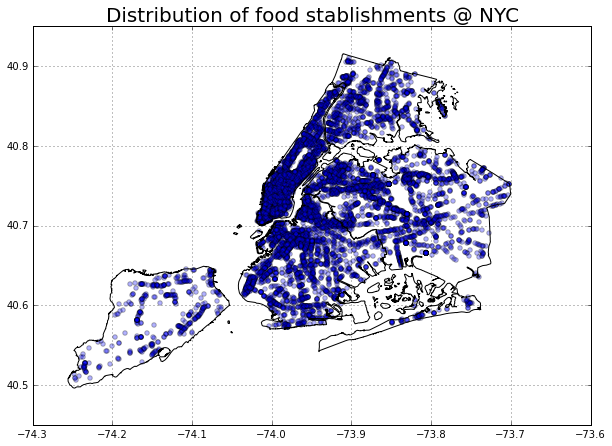

In [3]:
#Plotting geographical distribution of the points
plt.figure(figsize=(10,8))
boros.plot(alpha=0)
plt.scatter(latlon.longitude, latlon.latitude, s=20, alpha=0.3)
plt.title("Distribution of food stablishments @ NYC", fontsize = 20)
plt.ylim([40.45, 40.95])
plt.xlim([-74.3, -73.6])
plt.grid()

(-0.026560073573962971, 0.0017375595850500465)


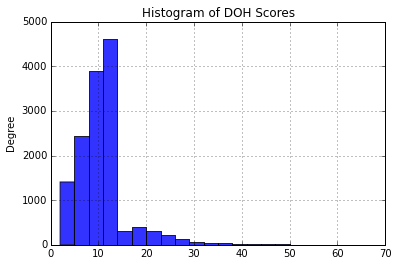

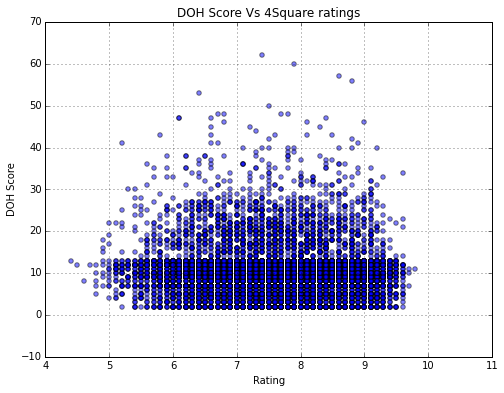

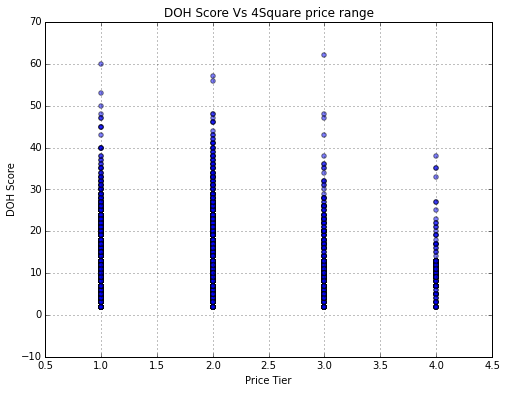

In [4]:
ax3 = food['SCORE'].plot(kind='hist', bins = 20, figsize=(6,4), grid=True, 
                title="Histogram of DOH Scores", alpha=0.8)
ax = food.plot(x='rating', y='SCORE', kind='scatter', figsize=(8,6), grid=True,
          title="DOH Score Vs 4Square ratings", alpha=0.5) 
ax.set(xlabel="Rating", ylabel="DOH Score")          
print(spst.pearsonr(food.rating, food.SCORE))
ax1 = food.plot(x='price.tier', y='SCORE', kind='scatter', figsize=(8,6), 
                grid=True, title="DOH Score Vs 4Square price range", alpha=0.5)
ax1.set(xlabel="Price Tier", ylabel="DOH Score")

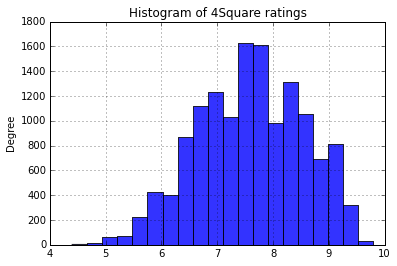

In [5]:
ax2 = food['rating'].plot(kind='hist', bins = 20, figsize=(6,4), grid=True,
                 title="Histogram of 4Square ratings", alpha=0.8)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


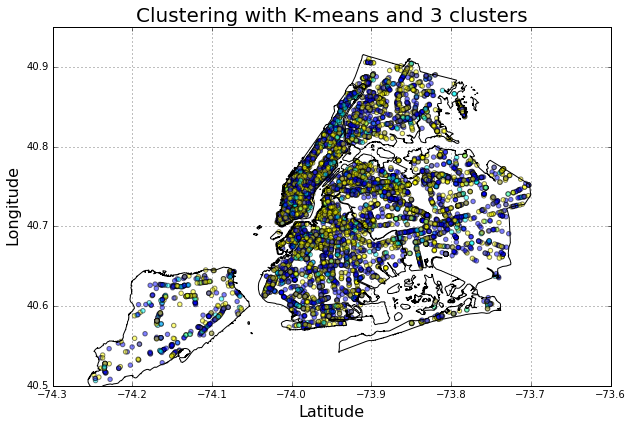

In [6]:
#Subsetting and whitening the data for clustering
food_sel = food[['rating','SCORE','price.tier', 'stats.checkinsCount']]
food_sel['price.tier'] = food_sel['price.tier'].fillna(value=1)
food_sel1 = food_sel[['rating', 'SCORE']]
food_sel1_scaled = preprocessing.scale(food_sel1)
food_sel_scaled = preprocessing.scale(food_sel)

#Clustering with kmeans and only rating and DOH Score
k = 3
est = cluster.KMeans(n_clusters = k, n_init = 100)
est.fit(food_sel1_scaled)
colors = est.labels_.astype(np.float) 
cmap = ListedColormap(['blue','green','yellow','red', 'cyan'])
plt.figure(figsize=(10, 8))
boros.plot(alpha=0)
plt.scatter(latlon.longitude, latlon.latitude, s=20, c=colors, cmap=cmap, 
            alpha = 0.5)
plt.title("Clustering with K-means and 3 clusters", fontsize = 20)
plt.xlabel('Latitude', fontsize=16)
plt.ylabel('Longitude', fontsize=16)
plt.ylim([40.5, 40.95])
plt.xlim([-74.3, -73.6])
plt.grid()

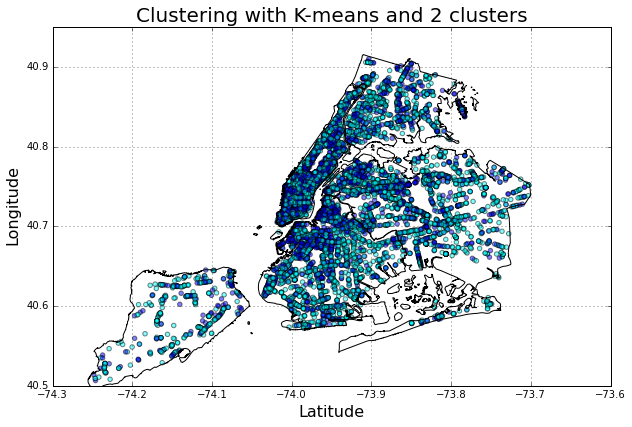

In [7]:
#Clustering with kmeans and all featrures (rating, DOH Score, price tier and
#4squared checkins)
k = 2
est = cluster.KMeans(n_clusters = k, n_init = 100)
est.fit(food_sel_scaled)
colors = est.labels_.astype(np.float)
cmap = ListedColormap(['blue','green','yellow','red', 'cyan'])
plt.figure(figsize=(10, 8))
boros.plot(alpha=0)
plt.scatter(latlon.longitude, latlon.latitude, s=20, c=colors, cmap=cmap, 
            alpha =0.5)
plt.title("Clustering with K-means and 2 clusters", fontsize = 20)
plt.xlabel('Latitude', fontsize=16)
plt.ylabel('Longitude', fontsize=16)
plt.ylim([40.5, 40.95])
plt.xlim([-74.3, -73.6])
plt.grid()

In [8]:
food_sel_scaled_df = pd.DataFrame(preprocessing.scale(food_sel), columns =['rating','SCORE','price.tier', 'stats.checkinsCount'])

In [9]:
#Dividing the sample into train and test sets
np.random.seed(2015)
ind=spst.bernoulli.rvs(p = 0.75, size = len(food_sel1))
food_sel_scaled_train = food_sel_scaled_df[ind==1]
food_sel_scaled_test = food_sel_scaled_df[ind==0] 

#Creating parameters for training RNN
n_hidden = 5 # M
n_in = 3      # D
n_out = 1     # K
n_steps = 1  # the length of each sequence
n_seq = len(food_sel_scaled_train)   # the number of datapoints (i.e. sequences)

#Creating input and output arrays for training RNN         
rating = np.array(food_sel_scaled_train[['rating','price.tier','stats.checkinsCount']]).reshape(n_seq,n_steps,n_in)
score = np.array(food_sel_scaled_train['SCORE']).reshape(n_seq,n_steps,n_out)

In [10]:
#Creating the model and feeding it with training data set
model = MetaRNN(n_in=n_in, n_hidden=n_hidden, n_out=n_out,
                    learning_rate=0.001, learning_rate_decay=0.999,
                    n_epochs=50, activation='tanh')
model.fit(rating, score, validation_frequency=5000)

... building the model
... training
epoch 1, seq 5000/10400, train loss 1.028519 lr: 0.001000
epoch 1, seq 10000/10400, train loss 1.011052 lr: 0.001000
epoch 2, seq 4600/10400, train loss 1.008152 lr: 0.000999
epoch 2, seq 9600/10400, train loss 1.012338 lr: 0.000999
epoch 3, seq 4200/10400, train loss 1.005605 lr: 0.000998
epoch 3, seq 9200/10400, train loss 1.006091 lr: 0.000998
epoch 4, seq 3800/10400, train loss 1.011310 lr: 0.000997
epoch 4, seq 8800/10400, train loss 1.006735 lr: 0.000997
epoch 5, seq 3400/10400, train loss 1.004779 lr: 0.000996
epoch 5, seq 8400/10400, train loss 1.006430 lr: 0.000996
epoch 6, seq 3000/10400, train loss 1.005919 lr: 0.000995
epoch 6, seq 8000/10400, train loss 1.006206 lr: 0.000995
epoch 7, seq 2600/10400, train loss 1.053963 lr: 0.000994
epoch 7, seq 7600/10400, train loss 1.071692 lr: 0.000994
epoch 8, seq 2200/10400, train loss 1.009884 lr: 0.000993
epoch 8, seq 7200/10400, train loss 1.012270 lr: 0.000993
epoch 9, seq 1800/10400, train loss

rnn.py:336: UserWarning: The parameter 'updates' of theano.function() expects an OrderedDict, got <type 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (theano.compat.python2x.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  self.y: train_set_y[index]})


In [11]:
guess = model.predict(rating.reshape(len(rating), n_in))
scores_pred = pd.DataFrame(guess)

In [12]:
scores_pred.columns = ['predictions']

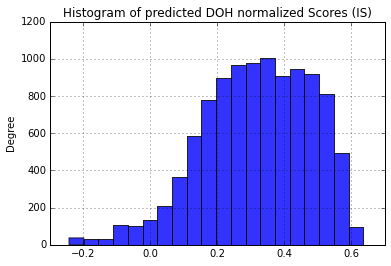

In [13]:
scores_pred.predictions.plot(kind='hist', bins=20, figsize=(6,4), grid=True,\
                             title = "Histogram of predicted DOH normalized Scores (IS)", alpha=0.8)

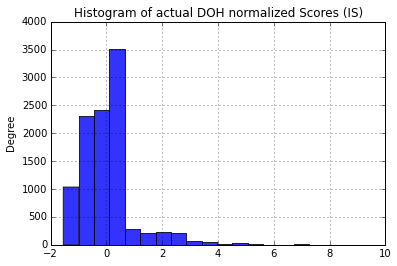

In [14]:
food_sel_scaled_train.SCORE.plot(kind='hist', bins=20, figsize=(6,4), grid=True,\
                             title = "Histogram of actual DOH normalized Scores (IS)", alpha=0.8)

In [15]:
#Creating parameters for training RNN
n_hidden = 5 # M
n_in = 3      # D
n_out = 1     # K
n_steps = 1  # the length of each sequence
n_seq = len(food_sel_scaled_test)   # the number of datapoints (i.e. sequences)

#Creating input and output arrays for training RNN         
rating1 = np.array(food_sel_scaled_test[['rating','price.tier','stats.checkinsCount']]).reshape(n_seq,n_steps,n_in)
score1 = np.array(food_sel_scaled_test['SCORE']).reshape(n_seq,n_steps,n_out)

In [16]:
guess1 = model.predict(rating1.reshape(len(rating1), n_in))
scores_pred1 = pd.DataFrame(guess1)

In [17]:
scores_pred1.columns = ['predictions']

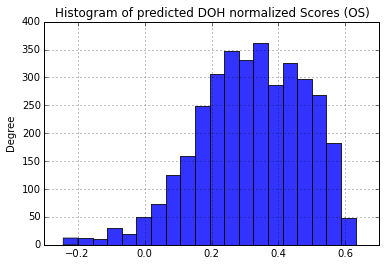

In [18]:
scores_pred1.predictions.plot(kind='hist', bins=20, figsize=(6,4), grid=True,\
                             title = "Histogram of predicted DOH normalized Scores (OS)", alpha=0.8)

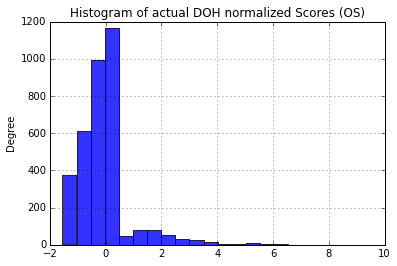

In [19]:
food_sel_scaled_test.SCORE.plot(kind='hist', bins=20, figsize=(6,4), grid=True,\
                             title = "Histogram of actual DOH normalized Scores (OS)", alpha=0.8)

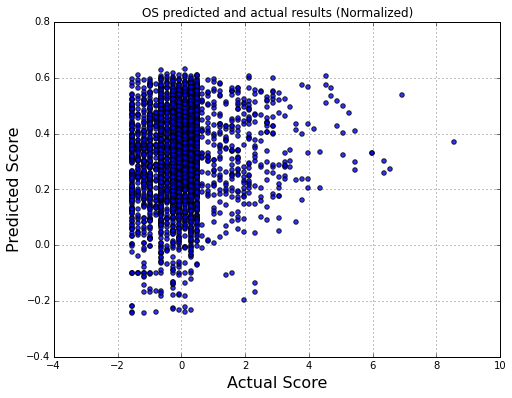

In [21]:
fig = plt.figure(figsize=(8,6))
ax = plt.scatter(x=food_sel_scaled_test.SCORE, y=scores_pred1.predictions,\
            alpha=0.8)
plt.grid()
plt.title('OS predicted and actual results (Normalized)')
plt.xlabel('Actual Score', fontsize=16)
plt.ylabel('Predicted Score', fontsize=16)

In [22]:
BCsubset = (food[food.SCORE > 13])

In [23]:
latlon1 = pd.DataFrame(list(BCsubset.latlon.str.split()))
latlon1.columns = ['latitude', 'longitude']
latlon1['latitude'] = latlon1['latitude'].map(lambda x: str(x)[:-1])
latlon1 = latlon1.astype(float)
latlon1 = latlon1[['longitude', 'latitude']]

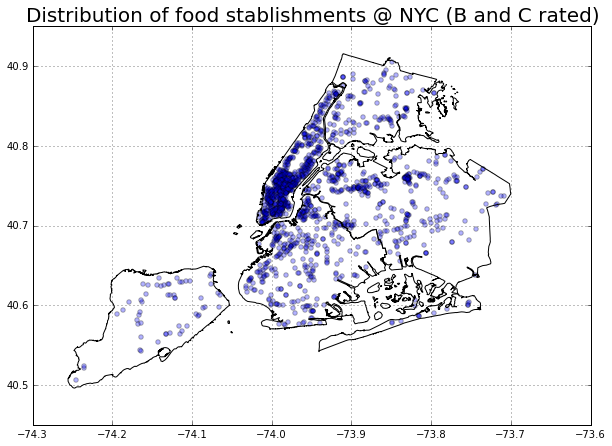

In [24]:
#Plotting geographical distribution of the points
plt.figure(figsize=(10,8))
boros.plot(alpha=0)
plt.scatter(latlon1.longitude, latlon1.latitude, s=20, alpha=0.3)
plt.title("Distribution of food stablishments @ NYC (B and C rated)", fontsize = 20)
plt.ylim([40.45, 40.95])
plt.xlim([-74.3, -73.6])
plt.grid()

(-0.0082251352088118304, 0.7456326384244325)


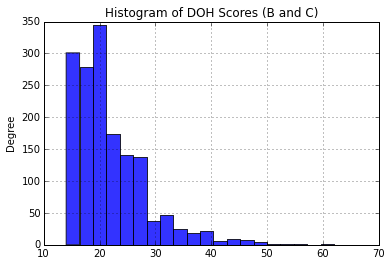

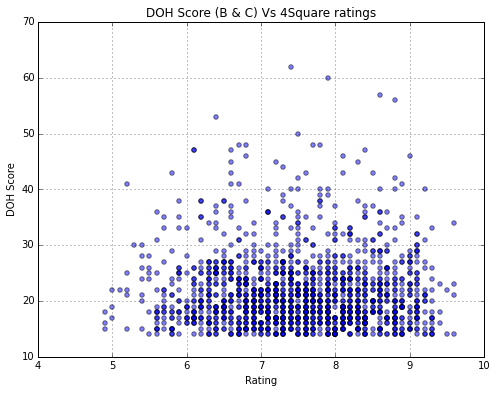

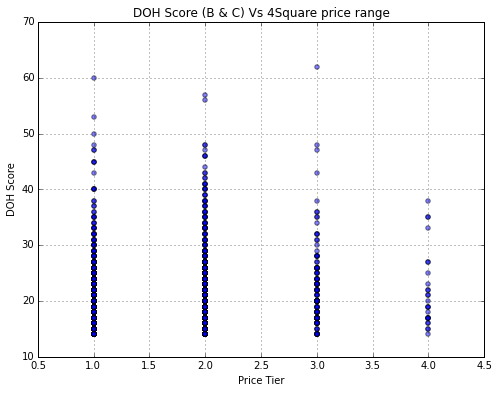

In [25]:
ax3 = BCsubset['SCORE'].plot(kind='hist', bins = 20, figsize=(6,4), grid=True, 
                title="Histogram of DOH Scores (B and C)", alpha=0.8)
ax = BCsubset.plot(x='rating', y='SCORE', kind='scatter', figsize=(8,6), grid=True,
          title="DOH Score (B & C) Vs 4Square ratings", alpha=0.5) 
ax.set(xlabel="Rating", ylabel="DOH Score")          
print(spst.pearsonr(BCsubset.rating, BCsubset.SCORE))
ax1 = BCsubset.plot(x='price.tier', y='SCORE', kind='scatter', figsize=(8,6), 
                grid=True, title="DOH Score (B & C) Vs 4Square price range", alpha=0.5)
ax1.set(xlabel="Price Tier", ylabel="DOH Score")

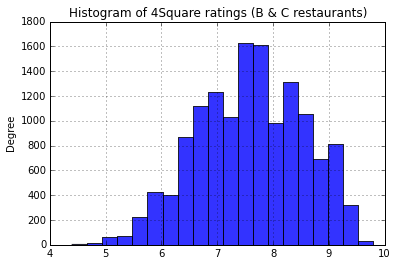

In [26]:
ax2 = food['rating'].plot(kind='hist', bins = 20, figsize=(6,4), grid=True,
                 title="Histogram of 4Square ratings (B & C restaurants)", alpha=0.8)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


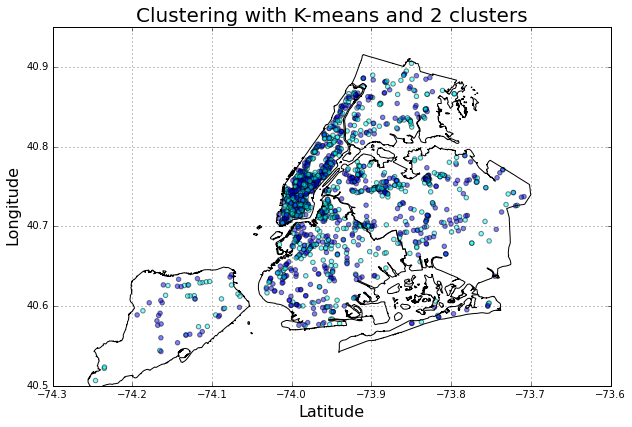

In [27]:
#Subsetting and whitening the data for clustering
BC_food_sel = BCsubset[['rating','SCORE','price.tier', 'stats.checkinsCount']]
BC_food_sel['price.tier'] = BCsubset['price.tier'].fillna(value=1)
BC_food_sel1 = BCsubset[['rating', 'SCORE']]
BC_food_sel1_scaled = preprocessing.scale(BC_food_sel1)
BC_food_sel_scaled = preprocessing.scale(BC_food_sel)

#Clustering with kmeans and only rating and DOH Score
k = 2
est = cluster.KMeans(n_clusters = k, n_init = 100)
est.fit(BC_food_sel1_scaled)
colors = est.labels_.astype(np.float) 
cmap = ListedColormap(['blue','green','yellow','red', 'cyan'])
plt.figure(figsize=(10, 8))
boros.plot(alpha=0)
plt.scatter(latlon1.longitude, latlon1.latitude, s=20, c=colors, cmap=cmap, \
            alpha = 0.5)
plt.title("Clustering with K-means and 2 clusters", fontsize = 20)
plt.xlabel('Latitude', fontsize=16)
plt.ylabel('Longitude', fontsize=16)
plt.ylim([40.5, 40.95])
plt.xlim([-74.3, -73.6])
plt.grid()

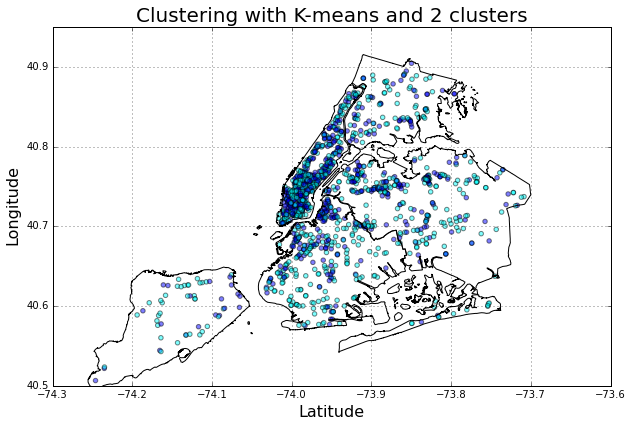

In [28]:
#Clustering with kmeans and all featrures (rating, DOH Score, price tier and
#4squared checkins)
k = 2
est = cluster.KMeans(n_clusters = k, n_init = 100)
est.fit(BC_food_sel_scaled)
colors = est.labels_.astype(np.float)
cmap = ListedColormap(['blue','green','yellow','red', 'cyan'])
plt.figure(figsize=(10, 8))
boros.plot(alpha=0)
plt.scatter(latlon1.longitude, latlon1.latitude, s=20, c=colors, cmap=cmap, 
            alpha =0.5)
plt.title("Clustering with K-means and 2 clusters", fontsize = 20)
plt.xlabel('Latitude', fontsize=16)
plt.ylabel('Longitude', fontsize=16)
plt.ylim([40.5, 40.95])
plt.xlim([-74.3, -73.6])
plt.grid()

In [29]:
BC_food_sel_scaled_df = pd.DataFrame(preprocessing.scale(BC_food_sel), columns =['rating','SCORE','price.tier',\
                                                                                 'stats.checkinsCount'])

In [30]:
#Dividing the sample into train and test sets
np.random.seed(2015)
ind=spst.bernoulli.rvs(p = 0.75, size = len(BC_food_sel))
BC_food_sel_scaled_train = BC_food_sel_scaled_df[ind==1]
BC_food_sel_scaled_test = BC_food_sel_scaled_df[ind==0] 

#Creating parameters for training RNN
n_hidden = 5 # M
n_in = 3      # D
n_out = 1     # K
n_steps = 1  # the length of each sequence
n_seq = len(BC_food_sel_scaled_train)   # the number of datapoints (i.e. sequences)

#Creating input and output arrays for training RNN         
BC_rating = np.array(BC_food_sel_scaled_train[['rating','price.tier','stats.checkinsCount']]).reshape(n_seq,n_steps,n_in)
BC_score = np.array(BC_food_sel_scaled_train['SCORE']).reshape(n_seq,n_steps,n_out)

In [31]:
#Creating the model and feeding it with training data set
model = MetaRNN(n_in=n_in, n_hidden=n_hidden, n_out=n_out,
                    learning_rate=0.001, learning_rate_decay=0.999,
                    n_epochs=200, activation='tanh')
model.fit(BC_rating, BC_score, validation_frequency=5000)

... building the model
... training
epoch 5, seq 416/1146, train loss 1.008296 lr: 0.000996
epoch 9, seq 832/1146, train loss 1.012437 lr: 0.000992
epoch 14, seq 102/1146, train loss 1.006322 lr: 0.000987
epoch 18, seq 518/1146, train loss 1.037245 lr: 0.000983
epoch 22, seq 934/1146, train loss 1.002330 lr: 0.000979
epoch 27, seq 204/1146, train loss 1.028100 lr: 0.000974
epoch 31, seq 620/1146, train loss 1.008887 lr: 0.000970
epoch 35, seq 1036/1146, train loss 1.021701 lr: 0.000967
epoch 40, seq 306/1146, train loss 1.023508 lr: 0.000962
epoch 44, seq 722/1146, train loss 1.000715 lr: 0.000958
epoch 48, seq 1138/1146, train loss 1.016593 lr: 0.000954
epoch 53, seq 408/1146, train loss 1.000088 lr: 0.000949
epoch 57, seq 824/1146, train loss 1.009790 lr: 0.000946
epoch 62, seq 94/1146, train loss 1.001943 lr: 0.000941
epoch 66, seq 510/1146, train loss 1.031044 lr: 0.000937
epoch 70, seq 926/1146, train loss 1.000082 lr: 0.000933
epoch 75, seq 196/1146, train loss 1.022348 lr: 0.000

In [32]:
BCguess = model.predict(BC_rating.reshape(len(BC_rating), n_in))
BCscores_pred = pd.DataFrame(BCguess)

In [33]:
BCscores_pred.columns = ['predictions']

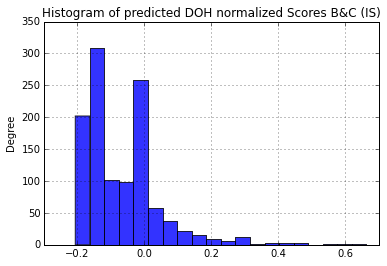

In [34]:
BCscores_pred.predictions.plot(kind='hist', bins=20, figsize=(6,4), grid=True,\
                             title = "Histogram of predicted DOH normalized Scores B&C (IS)", alpha=0.8)

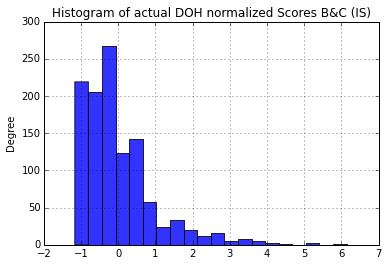

In [35]:
BC_food_sel_scaled_train.SCORE.plot(kind='hist', bins=20, figsize=(6,4), grid=True,\
                             title = "Histogram of actual DOH normalized Scores B&C (IS)", alpha=0.8)

In [36]:
#Creating parameters for training RNN
n_hidden = 5 # M
n_in = 3      # D
n_out = 1     # K
n_steps = 1  # the length of each sequence
n_seq = len(BC_food_sel_scaled_test)   # the number of datapoints (i.e. sequences)

#Creating input and output arrays for training RNN         
BC_rating1 = np.array(BC_food_sel_scaled_test[['rating','price.tier','stats.checkinsCount']]).reshape(n_seq,n_steps,n_in)
BC_score1 = np.array(BC_food_sel_scaled_test['SCORE']).reshape(n_seq,n_steps,n_out)

In [37]:
BCguess1 = model.predict(BC_rating1.reshape(len(BC_rating1), n_in))
BCscores_pred1 = pd.DataFrame(BCguess1)

In [38]:
BCscores_pred1.columns = ['predictions']

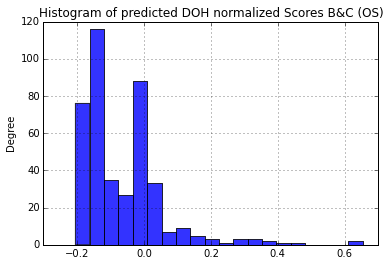

In [39]:
BCscores_pred1.predictions.plot(kind='hist', bins=20, figsize=(6,4), grid=True,\
                             title = "Histogram of predicted DOH normalized Scores B&C (OS)", alpha=0.8)

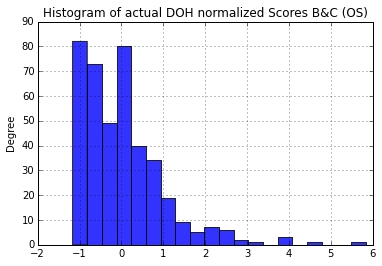

In [40]:
BC_food_sel_scaled_test.SCORE.plot(kind='hist', bins=20, figsize=(6,4), grid=True,\
                             title = "Histogram of actual DOH normalized Scores B&C (OS)", alpha=0.8)

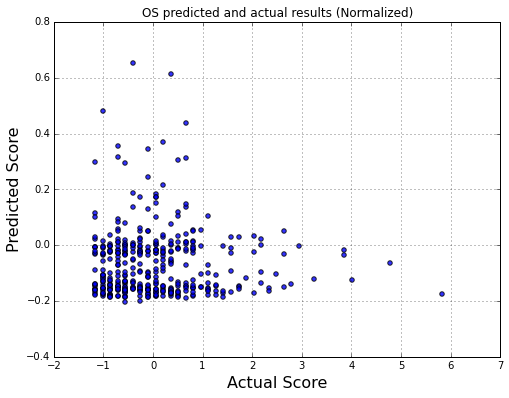

In [41]:
fig = plt.figure(figsize=(8,6))
ax = plt.scatter(x=BC_food_sel_scaled_test.SCORE, y=BCscores_pred1.predictions,\
            alpha=0.8)
plt.grid()
plt.title('OS predicted and actual results (Normalized)')
plt.xlabel('Actual Score', fontsize=16)
plt.ylabel('Predicted Score', fontsize=16)